<a href="https://colab.research.google.com/github/reyhanfarrafi/Disease-Detection-Model-Algorithm/blob/main/RNN_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
!pip install keras-tuner
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt

In [ ]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()

Saving TA_Dataset1.csv to TA_Dataset1 (5).csv


In [ ]:
# Load the dataset
df = pd.read_csv('TA_Dataset1.csv', on_bad_lines='skip')

In [ ]:
# List of categorical columns to be encoded
categorical_columns = ['Disease', 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Gender', 'Blood Pressure', 'Cholesterol Level', 'Outcome Variable']

In [ ]:
# Initialize label encoder
label_encoder = LabelEncoder()
# Apply label encoding to each of the categorical columns
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [ ]:
# Split features and target variable
X = df.drop('Outcome Variable', axis=1)
y = df['Outcome Variable']

In [ ]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Reshape X for RNN [samples, time steps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [ ]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define function for hyperparameter tuning
def build_rnn_tuned(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Int('units_1', min_value=32, max_value=128, step=32),
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())

    model.add(SimpleRNN(
        units=hp.Int('units_2', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
        activation='relu',
        kernel_regularizer=l2(0.01)
    ))

    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Hyperparameter tuning

tuner = kt.RandomSearch(
    build_rnn_tuned,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='rnn_tuning',
    project_name='rnn_hyperparameter_tuning'
)

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Reloading Tuner from rnn_tuning/rnn_hyperparameter_tuning/tuner0.json


In [ ]:

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Units Layer 1: {best_hps.get('units_1')}
- Dropout Layer 1: {best_hps.get('dropout_1')}
- Units Layer 2: {best_hps.get('units_2')}
- Dropout Layer 2: {best_hps.get('dropout_2')}
- Dense Layer Units: {best_hps.get('dense_units')}
- Learning Rate: {best_hps.get('learning_rate')}
""")



Best hyperparameters:
- Units Layer 1: 128
- Dropout Layer 1: 0.1
- Units Layer 2: 16
- Dropout Layer 2: 0.1
- Dense Layer Units: 32
- Learning Rate: 0.001



In [ ]:
# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5634 - loss: 0.8944 - val_accuracy: 0.7316 - val_loss: 0.8057
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7307 - loss: 0.7097 - val_accuracy: 0.7828 - val_loss: 0.6937
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7653 - loss: 0.6009 - val_accuracy: 0.8361 - val_loss: 0.5900
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7883 - loss: 0.5532 - val_accuracy: 0.8689 - val_loss: 0.4986
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8274 - loss: 0.4893 - val_accuracy: 0.8832 - val_loss: 0.4358
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8545 - loss: 0.4252 - val_accuracy: 0.8934 - val_loss: 0.3887
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8556 - loss: 0.4121 - val_accuracy: 0.9016 - val_loss: 0.3455
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8532 - loss: 0.3772 - val_accuracy: 0.9057 - val_loss: 0.

In [ ]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9889 - loss: 0.0603 
Test Accuracy: 98.36%


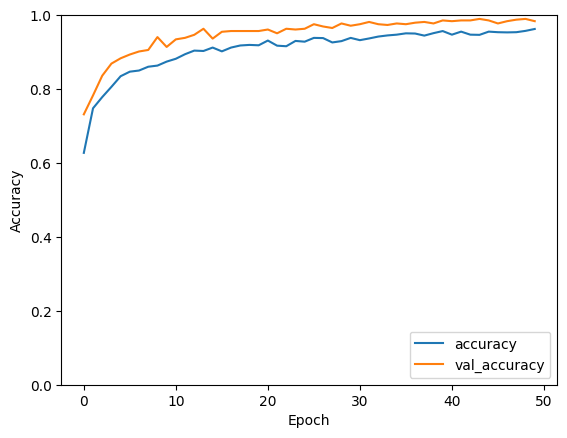

In [ ]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

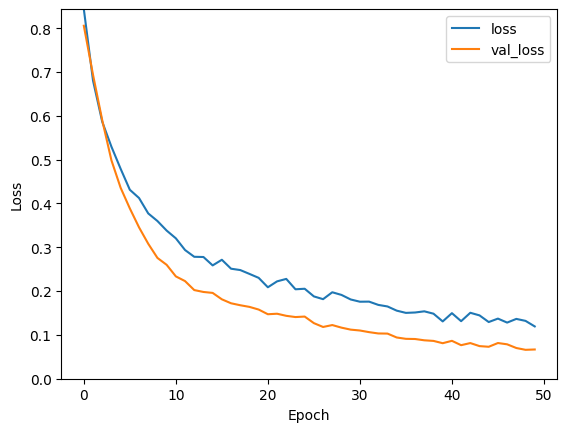

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'] + history.history['val_loss'])])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Predict on validation set
y_pred = best_model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       229
     Class 1       0.98      0.99      0.98       259

    accuracy                           0.98       488
   macro avg       0.98      0.98      0.98       488
weighted avg       0.98      0.98      0.98       488



In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

In [ ]:
# Calculate sensitivity
sensitivity = tp / (tp + fn)
print(f"Sensitivity: {sensitivity:.2f}")

Sensitivity: 0.99


In [ ]:
# Calculate specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

Specificity: 0.97


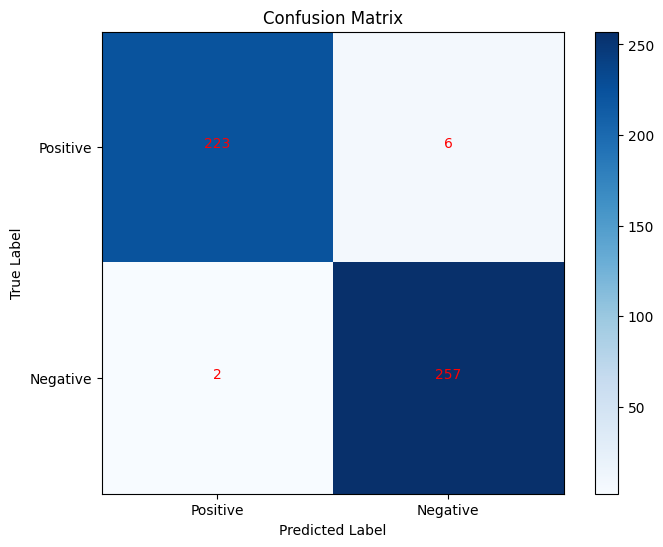

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Positive', 'Negative'])
plt.yticks(tick_marks, ['Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', color='red')

plt.show()